# Deep Reinforcement Learning Assignment

This assignment should be done in groups of 2 or 3 (preferably 3).

This assignment consists of two parts. In the first part, your task is to solve a grid world environment using the REINFORCE algorithm. In the second part, your task is to balance a pendulum attached to a cart such that it stays upright. You will implement the A2C algorithm that will learn a control policy for the cart.

## Imports 
Imports required packages. Add additional packages if needed.

In [1]:
import gymnasium as gym
import numpy as np

import torch

import tqdm

import matplotlib.pyplot as plt
from matplotlib.table import Table

# Part 1: GridWorld with REINFORCE (9 pts)
Firstly, you will implement REINFORCE in the GridWorld environment. The agent starts from the center, and the four actions left, right, up and down move the agent in the appropriate directions deterministically. The corner states are terminal and have the corresponding rewards.

**In this part, you should only use `numpy` operations (i.e., no automated differentiation with PyTorch).**

### The GridWorld Environment

We already provide a basic implementation of the grid world environment which you will use,
as well as the constants `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`.
You do not need to modify the class `GridWorld`.

In [2]:
#DO NOT MOIFY
ACTION_LEFT = 0
ACTION_RIGHT = 1
ACTION_UP = 2
ACTION_DOWN = 3

def clip(x, a, b):
    if x < a:
        return a
    if x > b:
        return b
    
    return x

class GridWorld:
    
    def __init__(self, size=3):
        self.size = size
        self.state = [0,0]
        self.actions = [ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN]
        
    def reset_world(self):
        self.state = [0,0]
    
    def is_terminal(self):
        return abs(self.state[0]) == self.size and abs(self.state[1]) == self.size
    
    def get_current_reward(self):
        if self.state == [self.size, self.size] or \
           self.state == [-self.size, -self.size]:
            return -1
        elif self.state == [-self.size, self.size] or \
             self.state == [self.size, -self.size]:
            return +1
        else:
            return 0
        
    def list_actions(self):
        return self.actions
    
    def step(self, action):
        if action not in self.actions:
            raise NotImplementedError("Action not defined")
            
        if self.is_terminal():
            raise NotImplementedError("Epsiode terminated! Call reset_world first.")

        if action == ACTION_LEFT:
            self.state[0] = clip(self.state[0]-1, -self.size, self.size)
            
        elif action == ACTION_RIGHT:
            self.state[0] = clip(self.state[0]+1, -self.size, self.size)
            
        elif action == ACTION_UP:
            self.state[1] = clip(self.state[1]+1, -self.size, self.size)
            
        elif action == ACTION_DOWN:
            self.state[1] = clip(self.state[1]-1, -self.size, self.size)
        
    def get_coordinates(self):
        s = np.array(self.state)
        s[0] = s[0] + self.size
        s[1] = self.size - s[1]
        
        return s
    
    def get_state(self):
        return self.get_coordinates()[0] + \
               self.get_coordinates()[1] * (self.size * 2 + 1)
    
    def render_state(self):
        N = self.size
        x = self.state[0]
        y = self.state[1]

        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()

        tb = Table(ax, bbox=[0,0, 1, 1])

        row_labels = np.arange(2 * N + 1)
        col_labels = np.arange(2 * N + 1)
        width, height = .5, .5

        values = np.zeros((N*2+1, N*2+1))
        values[0,0] = values[-1, -1] = 1
        values[-1,0] = values[0, -1] = -1

        cell_colors = ('white', 'whitesmoke')
        font_colors = ('black', 'white')

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            if cell_val !=  0.:
                text = "%.1f" % cell_val
                if cell_val > 0:
                    c = "lightblue"
                else:
                    c = "lightcoral"
            elif row_idx == N and col_idx == N:
                text = "start"
                c = "antiquewhite"
            else:
                text = ""
                c = cell_colors[idx]

            tb.add_cell(row_idx, col_idx, width, height,
                        text=text,
                        loc='center',
                        facecolor=c)

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[idx])

        pos = plt.Circle((0.5 + 1/(2 * N + 1) * x, 0.5 + 1/(2 * N + 1) * y + .04), 0.01, color='black')
        ax.add_patch(pos)
        ax.add_table(tb)

You can plot the environment with `render_state()`

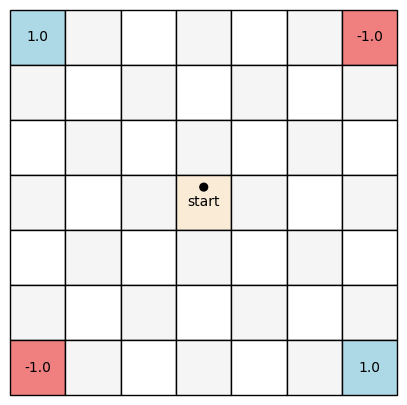

In [3]:
GridWorld().render_state()

The state after the agent takes the action `ACTION_RIGHT`

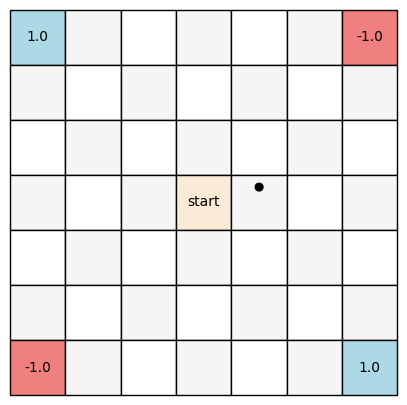

In [4]:
world = GridWorld()
world.reset_world()
world.step(ACTION_RIGHT)
world.render_state()

Cells/states are numbered from 0 to 48, left to right, top to bottom

In [5]:
world.get_state()

25

For convenience, cells are given coordinates left to right, top to bottom

In [6]:
world.get_coordinates()

array([4, 3])

### Direct Parameterization

In this part, we will define the policy according to an exponential softmax distribution where action preferences are linear using feature vectors \phi_{s,a}:
$$
\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_{a'} {\exp{\theta^\top \phi_{s,a'}}}}
$$

We will assume that the vectors $\phi_{s,a} \in \mathbb{R}^{|\mathcal{S}||\mathcal{A}|}$ are encoded as standard unit basis vectors (i.e., one-hot encoding).
First, we will create an appropriate encoding function for the states in GridWorld.

For consistency, we assume the actions are mapped to integers with `ACTION_LEFT=0, ACTION_RIGHT=1, ACTION_UP=2, ACTION_DOWN=3`, and the cell states are given values from 0 to 48, starting from left to right, from the top row to the bottom row. 
Note that `GridWorld.get_state()` implements the correct order on grid cells.
$\phi_{s,a}$ is assumed to be the unit vector with only the entry at position $4\times s + a$ equal to 1.





**Task 1.1 (0.5 pt):** Create a function `get_features_onehot` that encodes each $\phi_{s,a}$ with a one hot encoded vector in $\mathbb{R}^{|\mathcal{S}||\mathcal{A}|} = \mathbb{R}^{196}$ as a numpy vector.

In [7]:
def get_features_onehot(state:int, action:int):
    """Given the tuple (x,y) indicating the coordinates on the grid world, return one hot encoded features
    
    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """
    num_states = 49
    num_actions = 4

    features = np.zeros(num_states * num_actions)

    # Compute the index corresponding to the (state, action) pair
    index = state * num_actions + action
    features[index] = 1
    
    return features

**Task 1.2 (0.5 pt):** Implement an initialisation for the parameters $\theta \in \mathbb{R}^{196}$ as a numpy vector that you think is appropriate for efficient exploration.

In [8]:
def get_initial_parameters():
    """Returns vector of size 196 of initial parameters theta"""
     
   # return np.zeros(196)
    return np.random.normal(loc=0.0, scale=0.1, size=196)
   # return np.random.uniform(low=0.9, high=1.0, size=196)
   # return np.random.uniform(low=0.0, high=1.0, size=196)
    


**Task 1.3 (2 pts):** 
Calculate the partial derivatives $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$.
First, write down the analytic formula for the derivative *in the Markdown cell below (use LaTeX-math mode for equations, etc.).* Show your computation steps! 


Then, using your expression fill in `direct_parameterisation_derivative`, that will return the vector $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$ given a value of $\theta$ and action-state pair $a,s$.

**Hint:** For the analytic part, you may write down the formula for $\frac{\partial \pi_\theta(a|s)}{\partial \theta_{a',s'}}$, i.e., the partial derivative with respect to the entry of $\theta$ corresponding to any action-state pair $a', s'$.

**Hint:** The function `direct_parameterisation_derivative` should return a vector of size $4 |S| = 4 \times 7^2=196$, since you have 4 actions and $7^2$ states.

**Hint:** Only 4 entries of $\frac{\partial \pi_\theta(a|s)}{\partial \theta} \in \mathbb{R}^{196}$ should be nonzero for fixed $a,s$.

### Answer

Starting from $\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_{a'} {\exp{\theta^\top \phi_{s,a'}}}}$, we differentiate the numerator and denominator separately and then apply the quotient rule on the expression.

For the numerator $\exp(\theta^\top \phi_{s,a})$ the derivative with respect to $ \theta$ is 

$\frac{\partial}{\partial \theta} \exp(\theta^\top \phi_{s,a}) = \exp(\theta^\top \phi_{s,a}) \cdot \frac{\partial}{\partial \theta} \left( \theta^\top \phi_{s,a} \right) = \exp(\theta^\top \phi_{s,a}) \cdot \phi_{s,a}$


The denominator $ \sum_{a'} \exp(\theta^\top \phi_{s,a'})$ the derivative with respect to $\theta$ is

$\frac{\partial}{\partial \theta} \left( \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \right) = \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \cdot \frac{\partial}{\partial \theta} \left( \theta^\top \phi_{s,a'} \right) = \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \cdot \phi_{s,a'}$


Now we apply the quotient rule to differentiate the policy $\pi_\theta(a|s)$

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta} = \frac{\left( \frac{\partial}{\partial \theta} \exp(\theta^\top \phi_{s,a}) \right) \cdot \left( \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \right) - \exp(\theta^\top \phi_{s,a}) \cdot \frac{\partial}{\partial \theta} \left( \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \right)}{\left( \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \right)^2}
$$

Substitute the expressions we computed for the numerator and denominator derivatives

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta} = \frac{\exp(\theta^\top \phi_{s,a}) \cdot \phi_{s,a} \cdot \sum_{a'} \exp(\theta^\top \phi_{s,a'}) - \exp(\theta^\top \phi_{s,a}) \cdot \sum_{a'} \exp(\theta^\top \phi_{s,a'}) \cdot \phi_{s,a'}}{\left( \sum_{a'} \exp{\left( \theta^\top \phi_{s,a'}\right)} \right)^2}
$$

Simplifying the expression by factoring out $ \exp(\theta^\top \phi_{s,a}) $

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta} = \pi_\theta(a|s) \left( \phi_{s,a} - \frac{\sum_{a'} \exp(\theta^\top \phi_{s,a'}) \cdot \phi_{s,a'}}{\sum_{a'} \exp(\theta^\top \phi_{s,a'})} \right)
$$

Further simplification since the second term inside the parentheses is the expectation of $\phi_{s,a'} $ weighted by the probabilities $ \pi_\theta(a'|s)$

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta} = \pi_\theta(a|s) \left( \phi_{s,a} - \sum_{a'} \pi_\theta(a'|s) \cdot \phi_{s,a'} \right)
$$



In [9]:

def direct_parameterisation_gradient(action: int, state: int, theta: np.ndarray, num_actions: int = 4, num_states: int = 49):
    """Returns the partial derivatives of the policy with respect to theta.
    
    Parameters:
    - action: The action taken (integer from 0 to 3).
    - state: The current state (integer from 0 to 48).
    - theta: The parameter vector of size (4 * 49).
    
    Returns:
    - grad: A numpy array of size 196, representing the gradient vector.
    """
    grad = np.zeros(num_actions * num_states)
    
    theta_sa = theta.reshape(num_states, num_actions)
    theta_s = theta_sa[state, :] 
    exp_theta_s = np.exp(theta_s)
    sum_exp_theta_s = np.sum(exp_theta_s)
    pi_s = exp_theta_s / sum_exp_theta_s  
    
    pi_a_s = pi_s[action]
    
    # Use get_features_onehot to create the one-hot encoded vector for the action taken in the current state
    one_hot_action = get_features_onehot(state, action)

    # Compute the gradient components
    for a_prime in range(num_actions):
        idx = state * num_actions + a_prime  
        delta = one_hot_action[idx]  
        grad[idx] = pi_a_s * (delta - pi_s[a_prime])
    
    return grad


The code below helps you check if your derivative implementation is correct.
In case your implementation works, the code should print success.
You should not modify the cell below.

In [10]:
# DO NOT MODIFY
# checks the code above
torch.manual_seed(0)
success = True
N = 10
err = 0.

for i in range(N):
    theta = torch.rand((4*49))
    theta.requires_grad = True
    
    for state in range(49):
        for action in range(4):
            by_state = torch.exp(theta).reshape(49,4)
            out_prob = by_state / by_state.sum(-1, keepdim=True)
            out_prob.reshape(-1)[action + state*4].backward()

            answer = direct_parameterisation_gradient(action, state, theta.detach().cpu().numpy())
            
            err += np.abs(answer - theta.grad.cpu().numpy()).sum()
            
            if not np.allclose(answer, theta.grad.cpu().numpy()):
                success = False
                
            theta.grad.zero_()
    
if success:
    print(f"Success: errors within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
else:
    print(f"Fail: errors not within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
    
del theta, by_state, out_prob, answer

Success: errors within tolerance. Mean abs. error: 2.6751136466087323e-08


### REINFORCE Implementation

**Task 1.4 (0.5 pt):** In the lectures, you have been introduced to the REINFORCE algorithm. Explain in a few sentences what the regular REINFORCE objective aims to optimise and how it is achieved only using sample and no prior information on the MDP dynamics. 

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

The REINFORCE algorithm aims to optimise the expected return $J(\theta)$, and it uses the gradient policy theorem to estimate the gradient of the objective function with respect to the policy parameters. Monte-Carlo sampling from the trajectories is used to estimate this gradient by iteratively updating $\theta$ in the direction of the gradient, which is how the optimisation is achieved without knowledge of the MDP dynamics.

**Task 1.5 (3 pts):** Using your functions implemented in Task 1.1, 1.2 and 1.3, fill in the `ReinforceLearner` class. You can use the already implemented methods of the GridWorld class: 
- `reset_world`: reset the world to starting state
- `is_terminal`: is the current state terminal
- `get_current_reward`: reward of the current state
- `step`: given an action among `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`, takes a step in the simulation
- `get_state`: get current state, as an integer from 0 to 48
- `get_coordinates`: get current coordinates in table as a tuple (x,y)
- `render_state`: render the current state of the grid world, useful for debugging

**Hint:** You do not need to implement an exploration strategy with the appropriate intialisation, so only vanilla policy gradient steps should be sufficient for convergence with an appropriate learning rate.

In [11]:
class ReinforceLearner:

    def __init__(self, learning_rate, gamma):
        """Intialisation code"""
        
        self.world = GridWorld()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.theta = get_initial_parameters()
    
        
    def get_action_prob(self, state: int):
        """Given the state, return the probability of taking each of the 4 actions"""
        num_actions = 4
        theta_sa = self.theta.reshape(-1, num_actions)
        theta_s = theta_sa[state, :]  # Shape (4,)
        exp_theta_s = np.exp(theta_s)
        sum_exp_theta_s = np.sum(exp_theta_s)
        pi_s = exp_theta_s / sum_exp_theta_s  # π(a'|s) for all a'
        return pi_s
    
    def train(self, n_updates: int, n_trajectories: int):
        """Run the training procedure for n_updates steps
        
        n_trajectories: how many trajectories should be sampled each REINFORCE step
        n_updates: how many parameters updates to make (each parameter update would sample n_trajectories)"""
        
        rewards = []
        for episode in range(n_updates):
            rewards.append(self.reinforce_step(n_trajectories))
                
        return rewards
        
    def reinforce_step(self, n_trajectories: int):
        """Run a single gradient step for REINFORCE (without baseline) using n_trajectories many trajectories for estimation.
        
        Also return the average reward observed"""
        
        trajectories = []
        total_reward = 0
        
        for trajectory in range(n_trajectories):
            trajectory = []
            self.world.reset_world()
            state = self.world.get_state()
            done = False
            rewards = []
            
            while not done:
                action_probs = self.get_action_prob(state)
                action = np.random.choice(len(action_probs), p=action_probs)
                self.world.step(action)
                next_state = self.world.get_state()
                reward = self.world.get_current_reward()
                rewards.append(reward)
                trajectory.append((state, action, reward))
                state = next_state
                done = self.world.is_terminal()
            
            total_reward += sum(rewards)
            trajectories.append(trajectory)
        
        avg_reward = total_reward / n_trajectories
        
        # Update parameters
        for trajectory in trajectories:
            G = 0
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                G = reward + self.gamma * G
                grad = direct_parameterisation_gradient(action, state, self.theta)
                self.theta += self.learning_rate * G * grad
        
        return avg_reward
        
    def evaluate(self, render: bool = True):
        """Evaluate current algorithm for a single episode and return.
        
        You should 
        (a) Print the total reward from the episode.
        (b) Visualise the whole state history. (Hint: You can use multiple calls to GridWorld.render_state())"""
        
        self.world.reset_world()
        state = self.world.get_state()
        done = False
        total_reward = 0
        state_history = []
        
        while not done:
            action_probs = self.get_action_prob(state)
            action = np.argmax(action_probs)
            self.world.step(action)
            next_state = self.world.get_state()
            reward = self.world.get_current_reward()
            total_reward += reward
            state_history.append(self.world.get_coordinates())
            state = next_state
            done = self.world.is_terminal()
        
        print(f"Total reward: {total_reward}")
        
        if render:
            for coords in state_history:
                self.world.state = [coords[0] - self.world.size, self.world.size - coords[1]]
                self.world.render_state()

### Evaluation


**Task 1.6 (1 pt):** Run the above code until convergence, and evaluate your strategy at the end.
Plot the average reward observed per epoch during training.
You made need to tune your hyper-parameters. You policy should consistently visit the postive rewards to solve the environment.

Total reward: 1


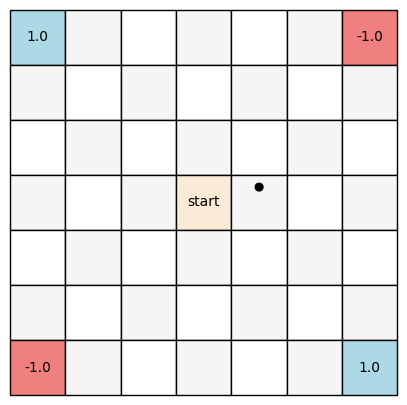

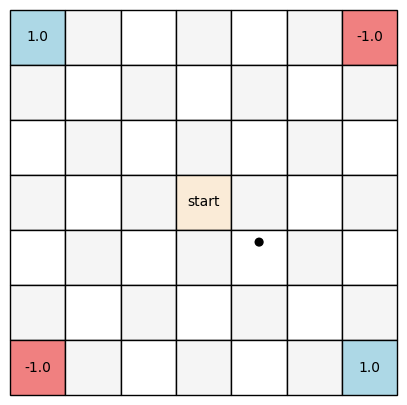

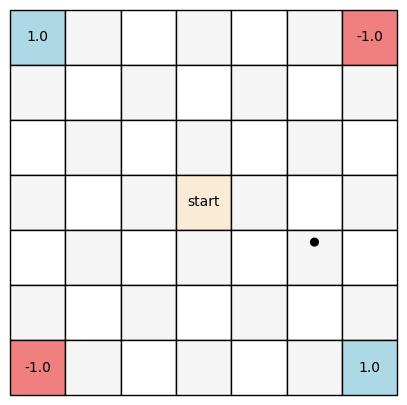

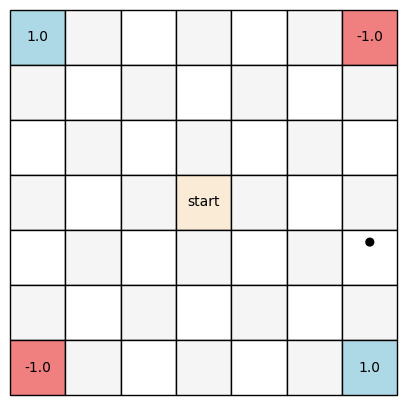

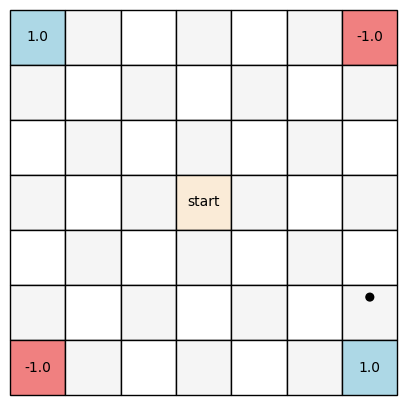

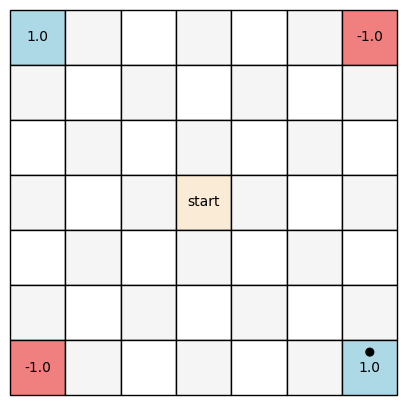

In [29]:
# TODO: Run your implementation for 1.5 here. 
# Remember to evaluate it at the end. Show your evalutation (including visualization of state history)!

# Initialize the learner
learner = ReinforceLearner(learning_rate=0.01, gamma=0.99)

# Train the learner
rewards = learner.train(n_updates=1000, n_trajectories=10)
cumulative_rewards = np.cumsum(rewards)

# Evaluate the final policy
learner.evaluate(render=True)

Text(0.5, 1.0, 'Cumulative reward during training')

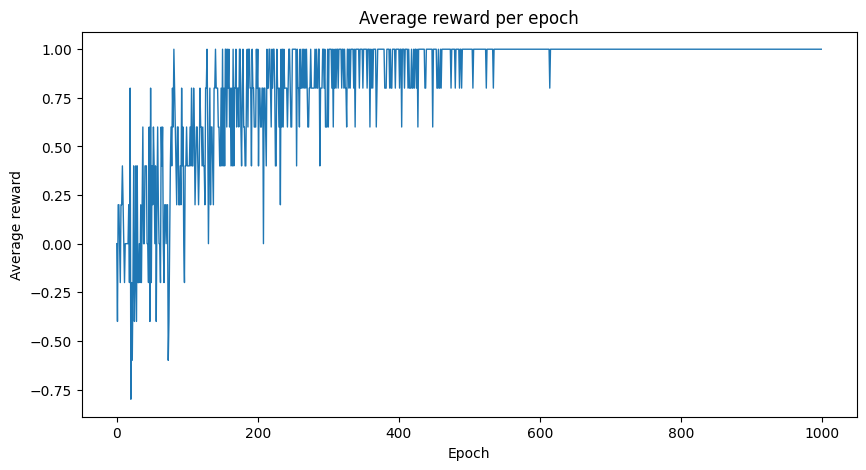

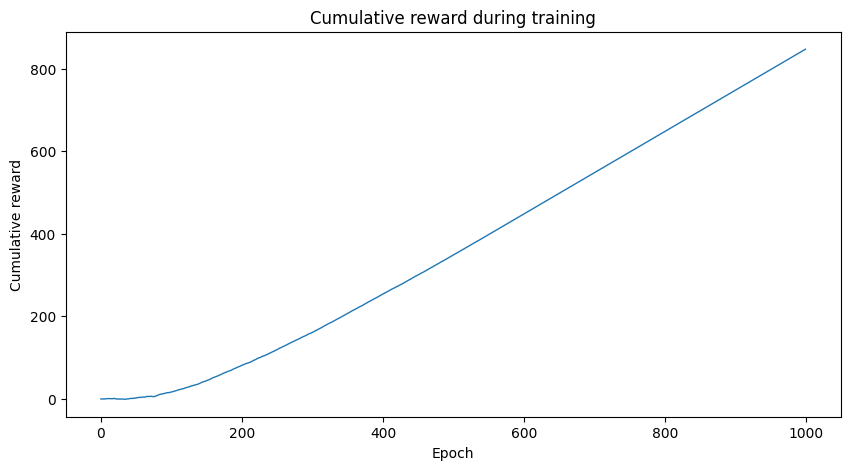

In [30]:
## TODO: Plot the average reward observed per epoch during training here

# Plot the average reward observed per epoch during training
plt.figure(figsize=(10, 5))
plt.plot(rewards, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Average reward')
plt.title('Average reward per epoch')

# Plot the cumulative reward observed during training
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Cumulative reward')
plt.title('Cumulative reward during training')

### Additional Questions


**Task 1.7 (1 pt):** The code above for REINFORCE does not implement an explicit exploration strategy.
Explain how the exploration-exploitation trade-off was circumvented by your choice of parameters intialisation in a few sentences, and how this approach could fail for some initialisations.

### Answer
If $\theta$ is initialized to small values (close to zero), the resulting softmax action probabilities are nearly uniform across all actions, promoting exploration since the agent is equally likely to select any action. Stochasticity in action selection is introduced through `np.random.choice(len(action_probs), p=action_probs)`, which randomly chooses an action based on the computed probabilities. This means that while actions with higher probabilities are more likely to be selected, all actions still have a non-zero chance of being chosen, allowing the agent to explore various options during learning. Choosing initial values for $\theta$ that is very high, may skew the action probabilities, making certain actions much more likely than others. This can cause the agent to overly rely on a limited set of actions. Consequently, the agent might become trapped in local optima. This could result in convergence problems.


**Task 1.8 (0.5 pt):** In a few sentences explain the shortcomings of the direct parametrisation.

### Answer
Direct parameterization involves directly mapping states to actions and it can struggle with the exploration-exploitation trade-off since it can get stuck in local optima and therefor not explore the full state space sufficiently. In turn this may lead to suboptimal policies. It also requires a large number of samples to learn an effective policy which hinders the performance.

##  Part 2: CartPole with A2C

### The Cart Pole Environment

The [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment is a classical problem where a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

Since the focus of this task is the implementation of reinforcement
learning algorithms, it is not necessary to have a detailed understanding of the mechanics of the
Cart Pole environment beyond the observation and action space sizes.

### Initialize the environment
Initialize the Cart Pole environment in the Gymnasium library to start learning a policy for it. You can read more about the Gymnasium library [here](https://gymnasium.farama.org/).

In [14]:
env = gym.make("CartPole-v1")

### PyTorch Intro

We also introduce basic functionality for PyTorch.
PyTorch is a widely used automatic differentiation library, which is very useful for training neural networks.
This part is also for guidance and does not include questions.
While we do introduce the basics of PyTorch, you are encouraged to explore more about the library following the official [tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) in case you haven't used it before.

PyTorch is built on top of the class `torch.Tensor`, which implements many operations on vectors, matrices and higher dimensional tensors.
The functionality of operations on torch tensors closely mirrors the operations from the `numpy` package.

In [15]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [16]:
a_matrix = [[1., 2.],[3., 4.]]
torch.tensor(a_matrix)

tensor([[1., 2.],
        [3., 4.]])

In [17]:
torch.matmul(torch.tensor(a_matrix), 
             torch.tensor([4., 5.]))

tensor([14., 32.])

What makes torch special is that it implements automated differentiation by tracking the operation history on tensors.
Namely, if a `torch.Tensor` has the propery `.requires_grad` set to `True`, torch will automatically track operations made on that tensor.
A final `.backward()` call to a computation result will compute partial derivatives of the variable with respect to all tensors in the tracked computational graph.
This is particularly useful for tracking derivatives with respect to a loss function, to enable simple gradient descent.

In [18]:
# example from https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

tensor(0.1459, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [19]:
# differentiate with respect to loss
loss.backward()
# the computed partial derivatives of w
w.grad

tensor([[0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001],
        [0.0111, 0.0153, 0.1001]])

To prevent tracking history, you can also wrap a piece of code in `with torch.no_grad():`. 
This can be particularly helpful when evaluating a model on new data, when training (and hence differentiation) is not required.

For more advanced modelling (as will be required by this exercise), it is usually useful to implement classes as children of `nn.Module`.
These implement the function `forward`, which returns the output of the forward pass of a model given inputs.
Modules have `nn.Parameter`, which will be the trainable parameters of the models.
Most useful sub-modules are already provided by the torch package: see for instance `nn.Linear`.

Finally, torch implements many standard optimizers: for instance `torch.optim.SGD`, `torch.optim.Adam`.
These are typically used to automatically take care of training once partial derivatives are computed.

### Advantage Actor-Critic (A2C)

A more stable alternative to vanilla policy gradients via REINFORCE is the so-called A2C algorithm, which is a actor-critic method.
First, you should familiarise yourself with the A2C algorithm reading the original [paper](https://arxiv.org/pdf/1602.01783.pdf).

**Task 2.1 (3 pts):** Explain in a few sentences each, 

1. how the A2C algorithm addresses the shortcomings of vanilla policy gradient methods,

2. the difference between A2C and A3C,

3. why the A3C algorithm could be expected to perform even better than A2C.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### 1)

Vanilla policy gradient methods like reinforce has a bit of high variance and instability which the AC2 tries to fix with using the critics value function as baseline to reduce variance and imrpove stability.

#### 2)

A3C uses parellelism i.e it runs multiple agents at the same time interacting with the envorinment independently (asynchronus) and uses their own parameters and local updates (which eventually update global shared parameters asynchronosly). The A2C is like a synchronus version where they run in parallel but they operate synchronusly where all agents wait until every agent has finished its segment before computing gradients, and synchronized to update parameters.

#### 3)

Firstly as mentioned, they operate asynchronosly which means that the agents don't have to wait for eachother to compute the gradients so they can operate at their own pace. Perhaps one of the agents will take a lot longer than the others, and in that case, waiting for all of the agents to finish will add alot of time delay, which A3C would avoid.

Using independent parameters will probably also mean that we get more diversity as they are more likley to explore different parts of the space at the same time.

### Neural Network Parameterization

We will use neural networks to parameterize both the value function and the policy.
The `ActorNet` defines the policy $\pi_\theta(a|s)$. Given state $s$ as input, it will output a distribution over the action space. 
The `CriticNet` defines the approximation to the value function, which could be denoted $\hat{V}_w(s)$. Given state $s$ as input, it will output an approximation of the state-value. 

You can play with different network architectures and the [activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) functions.
Note that the `ActorNet` should produce a probability distribution over the action space.

**Task 2.2 (0.5 pt):** Design your own neural networks for `ActorNet` and `CriticNet` in the code block below.

In [20]:
import torch
import torch.nn as nn

class ActorNet(torch.nn.Module):
    def __init__(self, num_state: int, num_action: int):
        super(ActorNet, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(num_state, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_action),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.network(state)
        

class CriticNet(torch.nn.Module):
    def __init__(self, num_state: int):
        super(CriticNet, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(num_state, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, state):
        return self.network(state)


### Learning Actor and Critic
We train both the actor and critic nets by interacting with the environment.
You implement the A2C training process below.

**Task 2.3 (4 pts):** 
Fill in and run the code below to implement A2C in the Cart Pole environment.
You should play with your hyper-parameters as well, to enable efficient learning.
You may play with different learning rates and optimizers.
For different optimizers in PyTorch, see [here](https://pytorch.org/docs/stable/optim.html).

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions
import tqdm

class A2C():
    
    def __init__(self, env, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3):
        """Initialization code"""
        # Initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0], 
                              env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # Set gamma and learning rates
        self.gamma = gamma
        actor_lr = actor_lr
        critic_lr = critic_lr
        
        self.env = env

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def train(self, max_iter: int = 1000, max_episode_len: int = 500):

        total_reward = []

        pbar = tqdm.tqdm(range(max_iter), desc="Episode")
        for num_iter in pbar:
            rewards = []
            log_probs = []
            values = []
            
            s, _ = self.env.reset()
            for t in range(max_episode_len):
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)  # Shape: [1, num_state]
                probs = self.actor(state)  # Shape: [1, num_action]
                
                # Create the distribution as current policy
                pi = torch.distributions.Categorical(probs)
                
                # Sample one action from this policy
                a = pi.sample()
                
                # Interact with the environment
                s_next, r, is_terminal, _, _ = self.env.step(a.item())
                
                # Store rewards and log probabilities
                rewards.append(r)
                log_probs.append(pi.log_prob(a))
                
                # Get the value estimate from the critic
                value = self.critic(state)
                values.append(value)
                
                s = s_next  # Update state

                if is_terminal:
                    break
                    
            # Store total_reward, do not modify
            total_reward.append(sum(rewards))
            avg_reward = sum(total_reward[-100:]) / min(len(total_reward), 100)
            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Mean last {min(len(total_reward),100)} episodes: {avg_reward:.2f}")
            
            # Prepare tensors
            log_probs = torch.stack(log_probs)       
            values = torch.cat(values).squeeze(-1)    
            rewards = torch.tensor(rewards, dtype=torch.float32) 
            
            # Compute returns (cumulative discounted rewards)
            returns = []
            R = 0
            if not is_terminal:
                # Estimate the value of the last state
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
                R = self.critic(state).item()
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32)  
            
            # Compute advantages for actor loss
            advantages = returns - values.detach()
            
            # Compute actor loss
            actor_loss = - (log_probs * advantages).mean()
            
            # Compute critic loss without detaching values
            critic_loss = (returns - values).pow(2).mean()
            
            # Update actor network
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()
            
            # Update critic network
            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()
        
        return total_reward



In [37]:
# TODO: Run your implementation here.

# Training hyperparameters
max_iter = 1000
max_episode_len = 600

gamma = 0.99
actor_lr = 1e-3
critic_lr = 1e-3

a2c = A2C(env, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)

total_reward = a2c.train(max_iter, max_episode_len)

Episode: 100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s, Last reward: 600.0, Mean last 100 episodes: 595.85]


**Useful hints:**

1. See [here](https://pytorch.org/docs/stable/distributions.html) for distributions in PyTorch. You may find the function `log_prob()` useful. You can easily compute $\log\pi(a|s)$ and its gradient using the function.

2. To optimize a model in PyTorch, you first define the loss function, then call the corresponding optimizer and perform backpropagation. For example, to optimize over the value function approximation, first let $\text{loss}=\|V_w-V^\pi\|^2$ and then call `loss.backward()` to compute the gradient.

3. You may find the function `detach()` defined in PyTorch useful if you need to call `backward()` multiple times on the same variables without storing the computational graph every time.

4. Maximizing $f(x)$ is equivalent to minimizing $-f(x)$. The default optimizers in PyTorch perform minimization.

5. You may find the classes `torch.nn.Softmax`, `torch.nn.ReLU`, `torch.nn.Tanh` useful when implementing a neural network architecture.

### Analyze your results
You can run the codes below to test your algorithm.
These will help you understand if your algorithm is working, and will help us grade your implementation.

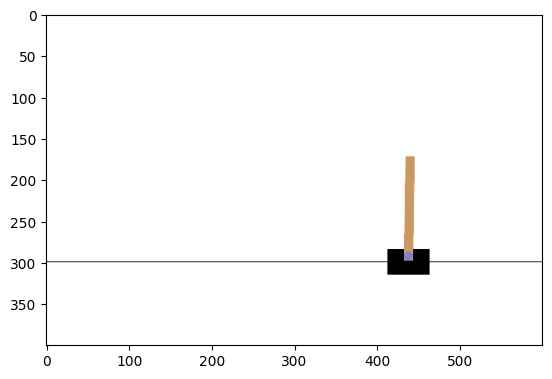

In [38]:
# This will visualize your learnt policy on the Cart Pole environment
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pygame


env_render = gym.make("CartPole-v1", render_mode="rgb_array")
for num_episode in range(1):
    s,_ = env_render.reset()
    tot_reward = []
    for t in range(max_episode_len):

        state = torch.tensor(s, dtype=torch.float).view(1, -1)
        
        prob = a2c.actor(state)
        policy = torch.distributions.categorical.Categorical(prob)
        action = policy.sample()
        s, r, is_terminal, _,_ = env_render.step(action.item())
        tot_reward.append(r)
        if is_terminal:
            print("Episode {} terminated after {} steps with reward {}. ".format(num_episode, t+1, sum(tot_reward)))
            break
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        
env_render.close()

We use a simple criteria to judge whether you solve the problem.
We will compute an average of the total reward over the previous 100 episodes at each iteration.
If there exists an iteration with average total reward larger than a threshold, as shown below, we will give you full grades.
That is, the problem is solved when the average reward is greater than or equal to 475 over 100 consecutive trials.

Note that `CartPole-v1` has a termination condition of 500 timesteps. It’s done so that one episode doesn’t take forever.
So we say that if a policy can balance a pole for 500 time steps (and achieve 500 reward) it’s probably good enough.

Successfully solve the problem in 520 iterations.


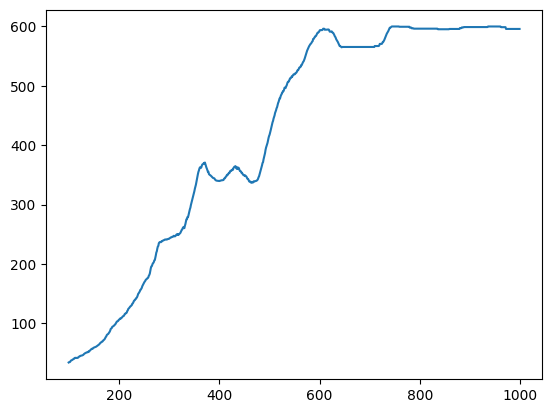

In [39]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward[:buffer_len])
avg_reward_1 = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward[num_iter]
    buffer_sum -= total_reward[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward_1.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward)), avg_reward_1)
plt.show()

### Entropy regularized A2C

The exploration-exploition trade-off is also a significant problem to be solved in the context of policy gradients.
There have been numerous approaches in literature aimed towards maximizing exploration in a principled and theoretically meaningful manner.
One such example is the entropy regularised policy gradient objective:
$$
J_\tau(\theta) = J(\theta) + \tau \mathbb{E}_{s \sim d^\pi_s}\left[-\sum_a \pi_\theta(a|s) \log \pi_\theta(a|s)\right],
$$
where $J(\theta)$ is the vanilla policy gradient objective and $\tau$ is a hyperparameter controlling regularisation.

**Task 2.4 (0.5 pt):** Explain why entropy regularization is relevant for encouraging exploration.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

With entropy regularization we promote higher randomness/uncertanty. This will hopefully lead to more exploration and avoiding premature convergence to suboptimal actions i.e we can use this to prevent the policy to collapse to deteremenistic choices so the agents can explore a wider range of actions and hopefully discover more optimal behaviours that may have been missed otherwise.

**Task 2.5 (1 pt):** Modify the training code from above to demonstrate A2C with entropy regularization. Implement a new loss function that returns your modified loss with entropy regularization. Use entropy regularisation on the CartPole task. Visualize your results and show that you have solved the problem. Compare to your results without entropy regularization in **Task 2.3**.

Also feel free to explore different values of $\tau$ and it's effect on the policy optimization process.

In [40]:

class A2CEntropy():
    
    def __init__(self, env, entropy_coef=0.01, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3):
        """Initialization code"""
        # Initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0], 
                              env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # Set gamma and learning rates
        self.gamma = gamma
        actor_lr = actor_lr
        critic_lr = critic_lr
        
        self.env = env
        self.entropy_coef = entropy_coef  # Entropy regularization coefficient

        # Optimizers
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def train(self, max_iter: int = 1000, max_episode_len: int = 500):

        total_reward = []

        pbar = tqdm.tqdm(range(max_iter), desc="Episode")
        for num_iter in pbar:
            # At each iteration, we roll out an episode using current policy
            rewards = []
            log_probs = []
            values = []
            entropies = []
            
            s, _ = self.env.reset()
            for t in range(max_episode_len):
                # Given current state, the actor outputs probabilities for each action
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)  # Shape: [1, num_state]
                probs = self.actor(state)  # Shape: [1, num_action]
                
                # Create the distribution as current policy
                pi = torch.distributions.Categorical(probs)
                
                # Sample one action from this policy
                a = pi.sample()
                
                # Interact with the environment
                s_next, r, is_terminal, _, _ = self.env.step(a.item())
                
                # Store rewards, log probabilities, and entropy
                rewards.append(r)
                log_probs.append(pi.log_prob(a))
                entropies.append(pi.entropy())

                # Get the value estimate from the critic
                value = self.critic(state)
                values.append(value)
                
                s = s_next  # Update state

                if is_terminal:
                    break
                    
            # Store total_reward, do not modify
            total_reward.append(sum(rewards))
            avg_reward = sum(total_reward[-100:]) / min(len(total_reward), 100)
            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Mean last {min(len(total_reward),100)} episodes: {avg_reward:.2f}")
            
            # Prepare tensors
            log_probs = torch.stack(log_probs)        # Shape: [episode_length]
            entropies = torch.stack(entropies)        # Shape: [episode_length]
            values = torch.cat(values).squeeze(-1)    # Shape: [episode_length]
            rewards = torch.tensor(rewards, dtype=torch.float32)  # Shape: [episode_length]
            
            # Compute returns (cumulative discounted rewards)
            returns = []
            R = 0
            if not is_terminal:
                # Estimate the value of the last state
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
                R = self.critic(state).item()
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32)  # Shape: [episode_length]
            
            # Compute advantages for actor loss
            advantages = returns - values.detach()
            
            # Compute actor loss with entropy regularization
            actor_loss = - (log_probs * advantages).mean() - self.entropy_coef * entropies.mean()
            
            # Compute critic loss without detaching values
            critic_loss = (returns - values).pow(2).mean()
            
            # Update actor network
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()
            
            # Update critic network
            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()
        
        return total_reward


In [44]:
# TODO: Run your implementation here. 
max_iter_entropy = 1000
max_episode_len_entropy = 600

# Mysiga hyperparametrar som kan vara mysiga om det är mysigt
entropy_coef = 0.005
gamma = 0.99
actor_lr = 1e-3
critic_lr = 1e-3

a2c_entropy = A2CEntropy(env, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, entropy_coef=entropy_coef)

total_reward_entropy = a2c_entropy.train(max_iter_entropy, max_episode_len_entropy)

Episode: 100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s, Last reward: 600.0, Mean last 100 episodes: 595.06]


Successfully solve the problem in 265 iterations.


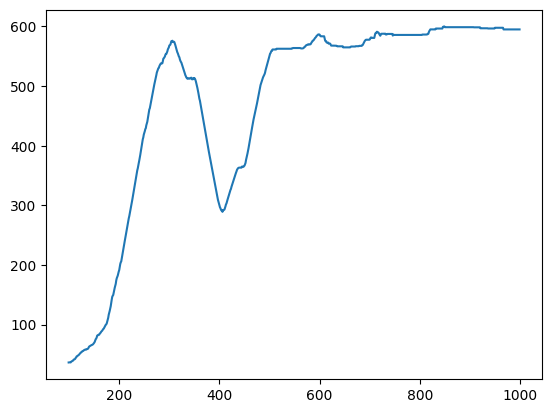

In [45]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward_entropy[:buffer_len])
avg_reward_2 = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward_entropy[num_iter]
    buffer_sum -= total_reward_entropy[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward_2.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward_entropy)), avg_reward_2)
plt.show()


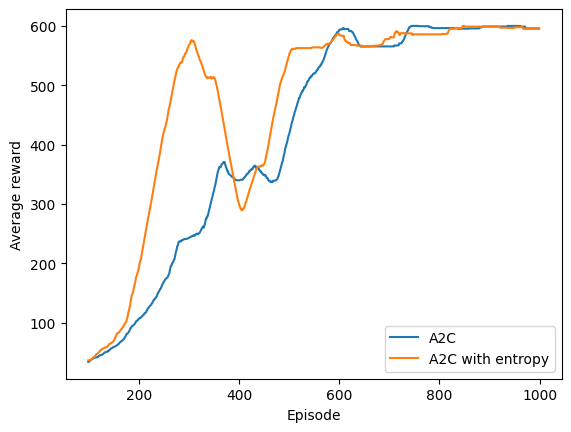

In [46]:
# TODO: Visualize your results and compare it to the results without entropy in Task 2.3

plt.plot(range(buffer_len-1, len(total_reward)), avg_reward_1, label="A2C")
plt.plot(range(buffer_len-1, len(total_reward_entropy)), avg_reward_2, label="A2C with entropy")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()
